In [171]:
import json
import pandas as pd
import numpy as np
import PySAM.Pvwattsv8 as PVWatts
import PySAM.Grid as Grid
import csv
import os
import geopandas as gpd
import math
import shutil 
from tqdm import tqdm
import shapely.wkt, shapely.geometry
from shapely.wkt import loads
from shapely import Polygon, oriented_envelope
from shapely.geometry import MultiPolygon

import matplotlib.pyplot as plt

def create_output_folder(directory, deleteFolder = False):
    if not(os.path.isdir(directory)):
        os.makedirs(directory)
    else:
        if(deleteFolder):
            shutil.rmtree(directory)
            os.makedirs(directory)

In [1]:
panelWidth = 1.879
panelHeight = 1.045

In [115]:
def rect(polygon, size=[panelWidth, panelHeight], tol=0, clip=True, include_poly=False):

    a, b, c, d = gpd.GeoSeries(polygon).total_bounds

    xa = np.arange(a, c + 1, size[0])
    ya = np.arange(b, d + 1, size[1])

    # offsets for tolerance
    if tol != 0:
        tol_xa = np.arange(0, tol * len(xa), tol)
        tol_ya = np.arange(0, tol * len(ya), tol)

    else:
        tol_xa = np.zeros(len(xa))
        tol_ya = np.zeros(len(ya))

    # combine placements of x&y with tolerance
    xat = np.repeat(xa, 2)[1:] + np.repeat(tol_xa, 2)[:-1]
    yat = np.repeat(ya, 2)[1:] + np.repeat(tol_ya, 2)[:-1]

    # create a grid
    grid = gpd.GeoSeries(
        [
            shapely.geometry.box(minx, miny, maxx, maxy)
            for minx, maxx in xat[:-1].reshape(len(xa) - 1, 2)
            for miny, maxy in yat[:-1].reshape(len(ya) - 1, 2)
        ]
    )

    if clip:
        grid = gpd.sjoin(
            gpd.GeoDataFrame(geometry=grid),
            gpd.GeoDataFrame(geometry=[polygon]),
            how="inner",
            predicate="within",
        )["geometry"]

    count = len(grid)

    if include_poly:
        grid = pd.concat(
            [
                grid,
                gpd.GeoSeries(
                    polygon.geoms
                    if isinstance(polygon, shapely.geometry.MultiPolygon)
                    else polygon
                ),
            ]
        )
    return grid, count

In [215]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

for parcel in os.listdir(parcelsFolder): # tqdm(os.listdir(parcelsFolder)[0:1], desc="Parcels", leave=True):
    parcelSubfolder = parcelsFolder + parcel + "/"
    for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]: #tqdm([x for x in os.listdir(parcelSubfolder)[0:1] if os.path.isdir(parcelSubfolder + x)],  desc="Constructions", leave=False):
        constructionFolder = parcelSubfolder + construction + "/"
        solarFolder = constructionFolder + "Solar Estimation Panels/"
        create_output_folder(solarFolder, deleteFolder=True)

        planesFiles = constructionFolder + "Plane Identification/" + construction + ".gpkg"
        planeGDF = gpd.read_file(planesFiles)

        for i in range(len(planeGDF)):
            row = planeGDF.iloc[i]

            tilt = row.tilt
            azimuth = row.azimuth
            geom = row.geometry
            centroid = geom.centroid
            
            if(tilt > 5): # Non-horizontal
                angle = azimuth
            else: # Horizontal
                orientedBB = oriented_envelope(geom)
                coords = list(orientedBB.exterior.coords)
                p1, p2 = coords[0], coords[1]
                dx = p2[0] - p1[0]
                dy = p2[1] - p1[1]
                angle_radians = math.atan2(dy, dx)
                angle = math.degrees(angle_radians)
  
            try:
                landscape_rotated = gpd.GeoSeries(geom).rotate(angle, origin=centroid)
                landscape_grid, landscape_count = rect(landscape_rotated.geometry[0], include_poly=False)

                portrait_rotated = gpd.GeoSeries(geom).rotate(angle+90, origin=centroid)
                portrait_grid, portrait_count = rect(landscape_rotated.geometry[0], include_poly=False)

                if(portrait_count > landscape_count):
                    grid_r = portrait_grid.rotate(-azimuth-90, origin=centroid)
                    count = portrait_count

                else:
                    grid_r = landscape_grid.rotate(-azimuth, origin=centroid)
                    count = landscape_count

                grid_r = gpd.GeoDataFrame(geometry=grid_r, crs=planeGDF.crs)
                # grid_r["cluster"] = row.cluster

                grid_r.to_file(solarFolder  + str(row.cluster) + ".gpkg")
            except:
                print(parcel, construction, row.cluster)
        

        # Combine all the rotated grids into a single geometry column
        # planeGDF["geometry"] = grids



4054901DF3845C 415 40
4054901DF3845C 487 9
4649601DF3844H 546 0


In [139]:
planeGDF.to_file(solarFolder  + construction + ".gpkg")

In [155]:
planeGDF2 = gpd.read_file(solarFolder  + construction + ".gpkg")
panel = loads(planeGDF2["panels"][0])

GEOSException: ParseException: Expected word but encountered number: '28'

In [149]:
planeGDF2["panels"][0]

'28     POLYGON ((434072.78 4585529.572, 434073.067 45...\n29     POLYGON ((434073.067 4585528.567, 434073.355 4...\n30     POLYGON ((434073.355 4585527.563, 434073.643 4...\n41     POLYGON ((434070.109 4585532.068, 434070.397 4...\n42     POLYGON ((434070.397 4585531.063, 434070.685 4...\n43     POLYGON ((434070.685 4585530.059, 434070.973 4...\n44     POLYGON ((434070.973 4585529.054, 434071.261 4...\n45     POLYGON ((434071.261 4585528.05, 434071.549 45...\n46     POLYGON ((434071.549 4585527.045, 434071.837 4...\n54     POLYGON ((434067.439 4585534.564, 434067.727 4...\n55     POLYGON ((434067.727 4585533.559, 434068.015 4...\n56     POLYGON ((434068.015 4585532.555, 434068.303 4...\n57     POLYGON ((434068.303 4585531.55, 434068.591 45...\n58     POLYGON ((434068.591 4585530.546, 434068.879 4...\n59     POLYGON ((434068.879 4585529.541, 434069.167 4...\n60     POLYGON ((434069.167 4585528.536, 434069.455 4...\n61     POLYGON ((434069.455 4585527.532, 434069.743 4...\n62     POLYGO

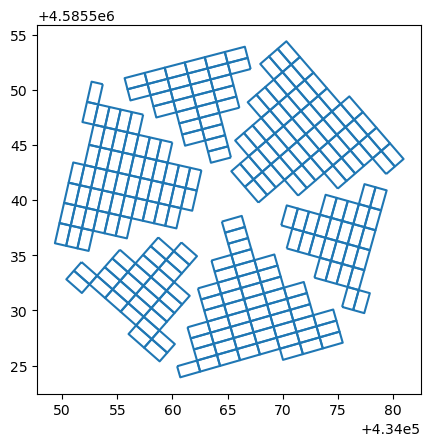

In [131]:
fig, ax = plt.subplots()  # Create a single axes object
for grid in grids:
    grid.exterior.plot(ax=ax)

TypeError: tuple indices must be integers or slices, not str

<Axes: >

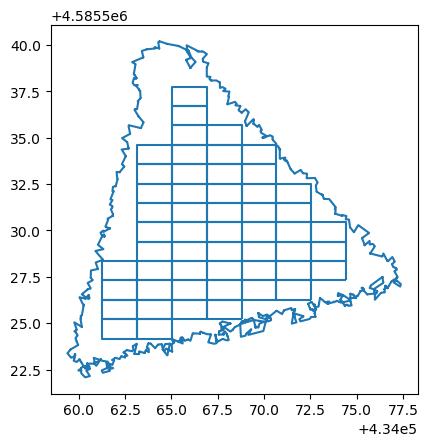

In [68]:
grid, count = rect(row.geometry, include_poly=True)
grid.exterior.plot()

<Axes: >

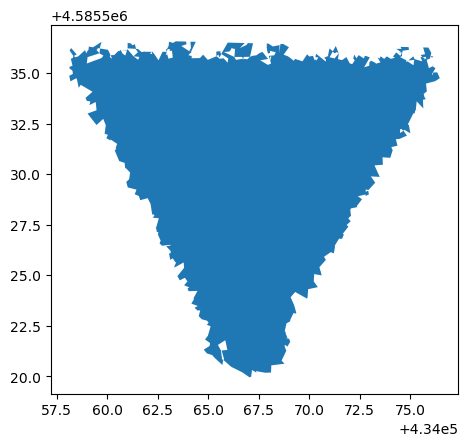

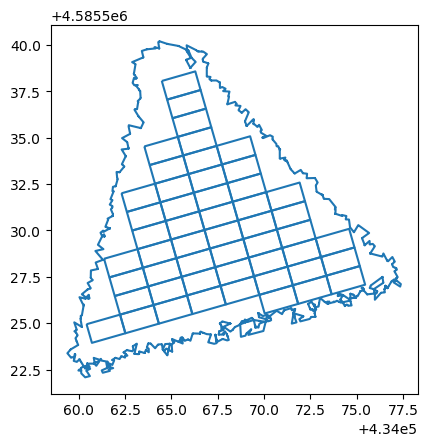

In [79]:
geom = row.geometry
centroid = geom.centroid
angle = row.azimuth
rotated = gpd.GeoSeries(geom).rotate(angle, origin=centroid)
rotated.plot()
grid, count = rect(rotated.geometry[0], include_poly=True)
grid_r = gpd.GeoSeries(grid).rotate(-row.azimuth, origin=centroid)
grid_r.exterior.plot()

In [82]:
len(grid)-len(rotated)

51

# Now trying with a flat surface

In [86]:
import json
import pandas as pd
import numpy as np
import PySAM.Pvwattsv8 as PVWatts
import PySAM.Grid as Grid
import csv
import os
import geopandas as gpd
import math
import shutil 
from tqdm import tqdm
import shapely.wkt, shapely.geometry

def create_output_folder(directory, deleteFolder = False):
    if not(os.path.isdir(directory)):
        os.makedirs(directory)
    else:
        if(deleteFolder):
            shutil.rmtree(directory)
            os.makedirs(directory)

In [87]:
panelWidth = 1.879
panelHeight = 1.045

In [93]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

for parcel in os.listdir(parcelsFolder)[1:2]: # tqdm(os.listdir(parcelsFolder)[0:1], desc="Parcels", leave=True):
    parcelSubfolder = parcelsFolder + parcel + "/"
    for construction in [x for x in os.listdir(parcelSubfolder)[0:1] if os.path.isdir(parcelSubfolder + x)]: #tqdm([x for x in os.listdir(parcelSubfolder)[0:1] if os.path.isdir(parcelSubfolder + x)],  desc="Constructions", leave=False):
        constructionFolder = parcelSubfolder + construction + "/"
        solarFolder = constructionFolder + "Solar Estimation Panels/"
        # create_output_folder(solarFolder, deleteFolder=True)

        planesFiles = constructionFolder + "Plane Identification/" + construction + ".gpkg"
        planeGDF = gpd.read_file(planesFiles)

        roofs = []
        for row in planeGDF.iterrows():
            
            pass
        row = planeGDF.iloc[3]


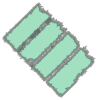

In [94]:
row.geometry

In [105]:
def rect(polygon, size=[1.879, 1.045], tol=0, clip=True, include_poly=False):

    a, b, c, d = gpd.GeoSeries(polygon).total_bounds

    xa = np.arange(a, c + 1, size[0])
    ya = np.arange(b, d + 1, size[1])

    # offsets for tolerance
    if tol != 0:
        tol_xa = np.arange(0, tol * len(xa), tol)
        tol_ya = np.arange(0, tol * len(ya), tol)

    else:
        tol_xa = np.zeros(len(xa))
        tol_ya = np.zeros(len(ya))

    # combine placements of x&y with tolerance
    xat = np.repeat(xa, 2)[1:] + np.repeat(tol_xa, 2)[:-1]
    yat = np.repeat(ya, 2)[1:] + np.repeat(tol_ya, 2)[:-1]

    # create a grid
    grid = gpd.GeoSeries(
        [
            shapely.geometry.box(minx, miny, maxx, maxy)
            for minx, maxx in xat[:-1].reshape(len(xa) - 1, 2)
            for miny, maxy in yat[:-1].reshape(len(ya) - 1, 2)
        ]
    )

    # make sure all returned polygons are within boundary
    if clip:
        # grid = grid.loc[grid.within(gpd.GeoSeries(np.repeat([polygon], len(grid))))]
        grid = gpd.sjoin(
            gpd.GeoDataFrame(geometry=grid),
            gpd.GeoDataFrame(geometry=[polygon]),
            how="inner",
            predicate="within",
        )["geometry"]
    count = len(grid)
    # useful for visualisation
    if include_poly:
        grid = pd.concat(
            [
                grid,
                gpd.GeoSeries(
                    polygon.geoms
                    if isinstance(polygon, shapely.geometry.MultiPolygon)
                    else polygon
                ),
            ]
        )
    return grid, count

595


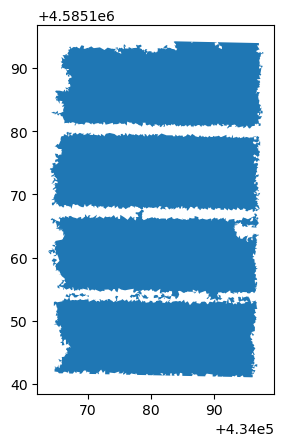

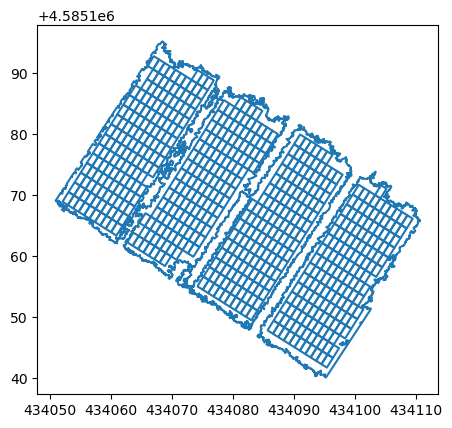

In [114]:
geom = row.geometry
centroid = geom.centroid

from shapely import Polygon, oriented_envelope
orientedBB = oriented_envelope(geom)
coords = list(orientedBB.exterior.coords)
p1, p2 = coords[0], coords[1]
dx = p2[0] - p1[0]
dy = p2[1] - p1[1]
angle_radians = math.atan2(dy, dx)
angle_degrees = math.degrees(angle_radians)

angle = angle_degrees+90
rotated = gpd.GeoSeries(geom).rotate(angle, origin=centroid)
rotated.plot()
grid, count = rect(rotated.geometry[0], include_poly=True)
grid_r = gpd.GeoSeries(grid).rotate(-row.azimuth, origin=centroid)
grid_r.exterior.plot()
print(count)

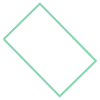